In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F    
from torch.optim import AdamW
from torch.amp import GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
from functools import partial

import json
import os

CHECKPOINT_DIR = os.path.join("..", "checkpoints", "GPT")
LOG_DIR = os.path.join("..", "logs", "GPT")
RESULTS_DIR = os.path.join("..", "results", "GPT")

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

In [ ]:
# add parent directory to the path to allow imports
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from GPT_mj import GPT, ConfigGPT
from train_mj import train, evaluate, ConfigTrain
from utils import init_dataloader, WarmupThenCosine, set_seed, count_params, save_checkpoint, load_checkpoint
from bpe_hf import train_bytelevel_bpe, SPECIAL_TOKENS

## load data

In [3]:
data_dir = "../data/"
# without nl
# train_file = "Shakespeare_clean_train.txt"
# val_file = "Shakespeare_clean_valid.txt"
# test_file = "Shakespeare_clean_test.txt"
# with nl
train_file = "Shakespeare_clean_w_nl_train.txt"
val_file = "Shakespeare_clean_w_nl_valid.txt"
test_file = "Shakespeare_clean_w_nl_test.txt"

train_file = os.path.join(data_dir, train_file)
test_file = os.path.join(data_dir, test_file)
val_file = os.path.join(data_dir, val_file)

with open(train_file, "r", encoding="utf-8") as f:
    train_text = f.read().strip()

with open(val_file, "r", encoding="utf-8") as f:
    val_text = f.read().strip()

with open(test_file, "r", encoding="utf-8") as f:
    test_text = f.read().strip()

print("train text charachters length: ", len(train_text))
print("train text words count: ", len(train_text.split()))
print("train text first 100 chars: ", train_text[:100])

train text charachters length:  883780
train text words count:  158605
train text first 100 chars:  The Tragedy of Antony and Cleopatra


Dramatis Personae



MARK ANTONY
OCTAVIUS CAESAR
M. AEMILIUS L


## initialize tokensizer and data embeddings

In [4]:
N_MERGES = 200
MIN_FREQ = 2

SPECIAL_TOKENS = SPECIAL_TOKENS.copy()
PAD_TOKEN = SPECIAL_TOKENS.get("pad", "<pad>")
BOS_TOKEN = SPECIAL_TOKENS.get("bos", "<bos>")
EOS_TOKEN = SPECIAL_TOKENS.get("eos", "<eos>")


bpe_tokenizer = train_bytelevel_bpe(files=[train_file],
                                merges=N_MERGES, 
                                min_frequency=MIN_FREQ,
                                special_tokens=SPECIAL_TOKENS,
                                lowercase=False,
                                add_prefix_space=True,
                                save_filename=f"bpe_shakespeare_{N_MERGES}")

encode = partial(bpe_tokenizer.encode, add_special_tokens=False)
decode = bpe_tokenizer.decode
vocab_size = bpe_tokenizer.get_vocab_size()
print("vocab size: ", vocab_size)
print("BPE tokenizer vocab: ", list(bpe_tokenizer.get_vocab().items())[:100])

PAD_TOKEN_ID = bpe_tokenizer.token_to_id(PAD_TOKEN) 
BOS_TOKEN_ID = bpe_tokenizer.token_to_id(BOS_TOKEN)
EOS_TOKEN_ID = bpe_tokenizer.token_to_id(EOS_TOKEN)

train_ids = encode(train_text).ids
test_ids = encode(test_text).ids
val_ids = encode(val_text).ids

print("train ids length: ", len(train_ids))
print("train ids first 100 ids: ", train_ids[:25])
print("train ids first 100 individual tokens: ", [bpe_tokenizer.id_to_token(i) for i in train_ids[:25]]) 

vocab size:  460
BPE tokenizer vocab:  [('n', 81), ('$', 7), ('ess', 410), ('at', 311), ('S', 54), ('<pad>', 0), ('ver', 389), ('_', 66), ('AR', 396), ('Ģ', 226), ('¦', 103), ('Ġo', 278), ('r', 85), ('US', 348), ('RA', 434), ('ā', 193), ('st', 309), ('nt', 359), ('Ġmu', 448), ('~', 97), ('ĠI', 277), ('il', 439), ('C', 38), ('ĸ', 248), ('±', 113), ('ı', 241), ('Ç', 135), ('IO', 442), ('j', 77), ('M', 48), ('pe', 413), ('id', 365), ('t', 87), ('ĠThe', 364), ('q', 84), ('ain', 408), ('Ġb', 275), ('³', 115), ('R', 53), ('ą', 197), ('ã', 163), ('Ď', 206), ('Ć', 198), ('«', 108), ('Z', 61), ('â', 162), ('Ġk', 381), ('ght', 354), ('ò', 178), ('ay', 320), ('V', 57), ('`', 67), ('Ġto', 298), ('Ġhis', 368), ('ĠD', 371), ('Ł', 257), ('Ġw', 268), ('-', 16), ('Ġmy', 323), ('à', 160), ('ake', 432), ('en', 289), ('Ġlo', 405), ('Ġthou', 369), ('es', 284), ('!', 4), ('ar', 290), ('čĊ', 260), ('a', 68), ('®', 110), ('he', 263), ('Į', 238), ('ĠĊ', 360), ('ķ', 247), (']', 64), ('{', 94), ('ĝ', 221), ('Ġan

## define the model's and training parameters (configs)

In [5]:
SEED = 123
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# hyperparameters 
# tokenizer
# N_MERGES = 200
# MIN_FREQ = 2
# data
BATCH_SIZE = 64
BLOCK_SIZE = 128

#  model
N_EMBED = 128
N_HEADS = 4
N_LAYERS = 2
DROPOUT = 0.1
# optimizer
LR = 3e-4
WEIGHT_DECAY = 1e-3
# scheduler
ETA_MIN = 1e-7

# training loop
EPOCHS = 60
ES_PATIENCE = 5
ES_TOLERANCE = 1e-6
GRAD_ACCUM_STEPS = 1
USE_AMP = False # IMPORTANT: set to False if training on CPU training 

# checkpoints
EVAL_INTERVAL = 2  # evaluate every n epochs
CKPT_INTERVAL = 10  # save checkpoint every n epochs

# make unique checkpoint file prefix from the parameters
ckpt_file_prefix = f"gpt_em{N_EMBED}_hd{N_HEADS}_ly{N_LAYERS}_bpe{N_MERGES}"
all_hparams_cfg_filename = f"{ckpt_file_prefix}_hparams.json"

# config for training
cfg_train = ConfigTrain(device=DEVICE,
                    epochs=EPOCHS, 
                    early_stop_patience=ES_PATIENCE,
                    early_stop_tolerance=ES_TOLERANCE,
                    grad_accum_steps=GRAD_ACCUM_STEPS,
                    # max_grad_norm=data.get("max_grad_norm", 1.0),
                    use_amp=USE_AMP,
                    seed=SEED,
                    eval_interval=EVAL_INTERVAL,
                    ckpt_interval=CKPT_INTERVAL,
                    ckpt_dir=CHECKPOINT_DIR,
                    ckpt_best_filename=f"{ckpt_file_prefix}_best.pt",
                    ckpt_last_filename=f"{ckpt_file_prefix}_last.pt",
                    log_dir=os.path.join(LOG_DIR, f"{ckpt_file_prefix}", f'lr{LR}_drop{DROPOUT}_{time.strftime("%y%m%d_%H%M%S")}'),
                    )
# config for model
cfg_model = ConfigGPT(
                    vocab_size=vocab_size,
                    block_size=BLOCK_SIZE,  
                    n_embed=N_EMBED,
                    n_head=N_HEADS,  
                    n_layer=N_LAYERS, 
                    dropout=DROPOUT,
                    bias=False,
                    )

# model parameters
print("vocab size: ", vocab_size)
print("number of model parameters: ", count_params(GPT(config=cfg_model)))

# print all log and checkpoint dir and filenames
print("number of batches in train loader: ", len(train_ids)//BATCH_SIZE)
print("number of batches in test loader: ", len(test_ids)//BATCH_SIZE)
print("number of batches in val loader: ", len(val_ids)//BATCH_SIZE)

print("log dir: ", cfg_train.log_dir)
print("checkpoint dir: ", cfg_train.ckpt_dir)
print("checkpoint best filename: ", cfg_train.ckpt_best_filename)
print("checkpoint last filename: ", cfg_train.ckpt_last_filename)

vocab size:  460
number of model parameters:  528460
number of batches in train loader:  7785
number of batches in test loader:  930
number of batches in val loader:  924
log dir:  logs/GPT/gpt_em128_hd4_ly2_bpe200/lr0.0003_drop0.1_250824_181825
checkpoint dir:  checkpoints/GPT
checkpoint best filename:  gpt_em128_hd4_ly2_bpe200_best.pt
checkpoint last filename:  gpt_em128_hd4_ly2_bpe200_last.pt


## Train the model

In [6]:
set_seed(cfg_train.seed)
train_loader = init_dataloader(train_ids, BLOCK_SIZE, BATCH_SIZE, train=True, shuffle=True)
test_loader = init_dataloader(test_ids, BLOCK_SIZE, BATCH_SIZE, train=False, shuffle=True)
val_loader = init_dataloader(val_ids, BLOCK_SIZE, BATCH_SIZE, train=False, shuffle=True)

model = GPT(config=cfg_model,)
model.to(cfg_train.device)

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, foreach=True if DEVICE=="cpu" else None)


lr_scheduler = WarmupThenCosine(optimizer, warmup_steps=500, T_max=cfg_train.epochs * len(train_loader) // max(1, cfg_train.grad_accum_steps), eta_min=ETA_MIN)
# rl_scheduler = CosineAnnealingLR(optimizer, T_max=cfg.epochs * len(train_loader) // max(1, cfg.grad_accum_steps), eta_min=ETA_MIN)
# rl_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=2 * len(train_loader) // max(1, cfg.grad_accum_steps), T_mult=2, eta_min=ETA_MIN)

scaler = GradScaler(enabled=cfg_train.use_amp)

summary_writer = SummaryWriter(log_dir=cfg_train.log_dir, flush_secs=5)

# add model graph to tensorboard
# write model graph
# dummy_input = torch.zeros((1, BLOCK_SIZE), dtype=torch.long, device=cfg_train.device)
# summary_writer.add_graph(model.eval(), dummy_input)  # eval() avoids dropout noise
# summary_writer.flush()
# summary_writer.close()

# compile the model (can skip if not needed)
model.compile(mode="reduce-overhead")

# inspect the model
print(f"Model parameters: {count_params(model):_}")
print("vocab size: ", vocab_size)
print(f"excepted iniital CE loss( uniform model ): {-np.log(1/vocab_size):.4f}, ppl: {np.exp(-np.log(1/vocab_size)):.4f}")
# evaluate the untrained model
val_loss = evaluate(model, val_loader, device=cfg_train.device)
val_ppl = np.exp(val_loss)
print(f"not trained model Initial validation loss: {val_loss:.4f}, ppl: {val_ppl:.4f}")
print(model)

Model parameters: 528_460
vocab size:  460
excepted iniital CE loss( uniform model ): 6.1312, ppl: 460.0000
not trained model Initial validation loss: 6.1553, ppl: 471.2037
GPT(
  (embedding): Embedding(460, 128)
  (position_embedding): Embedding(128, 128)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (decoder_blocks): Sequential(
    (0): DecoderBlock(
      (layer_norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attention): CausalSelfAttention(
        (self_attn): Linear(in_features=128, out_features=384, bias=False)
        (dropout_attn): Dropout(p=0.1, inplace=False)
        (lin_proj): Linear(in_features=128, out_features=128, bias=False)
        (dropout_proj): Dropout(p=0.1, inplace=False)
      )
      (layer_norm_mlp): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): SimpleMLP(
        (lin_wide): Linear(in_features=128, out_features=512, bias=False)
        (gelu): GELU(approximate='none')
        (lin_proj_back): Linear(in_features=

In [7]:
train_results = train(model, train_loader, val_loader, cfg=cfg_train,
                      optimizer=optimizer, scheduler=lr_scheduler, scaler=scaler,
                      writer=summary_writer)

Training Progress:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 2/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 3/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 4/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 5/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 6/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 7/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 8/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 9/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 10/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 11/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 12/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 13/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 14/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 15/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 16/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 17/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 18/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 19/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 20/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 21/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 22/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 23/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 24/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 25/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 26/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 27/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 28/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 29/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 30/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 31/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 32/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 33/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 34/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 35/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 36/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 37/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 38/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 39/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 40/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 41/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 42/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 43/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 44/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 45/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 46/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 47/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 48/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 49/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 50/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 51/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 52/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 53/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 54/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 55/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 56/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 57/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 58/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 59/60:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 60/60:   0%|          | 0/61 [00:00<?, ?it/s]

### save all parameters used in the model and training

In [8]:
# save all the hyperparameters into a json file
rl_scheduler_state_dict = lr_scheduler.state_dict() if lr_scheduler.__class__.__name__ != "WarmupThenCosine" else {
            k:v for k, v in lr_scheduler.state_dict().items() if k != "cosine"}
all_hparams_cfg = {
    "tokenizer" : {
        "type": "bytelevel_bpe",
        "n_merges": N_MERGES,
        "min_frequency": MIN_FREQ,
        "special_tokens": SPECIAL_TOKENS,
    },
    "data": {
        "batch_size": BATCH_SIZE,
        "block_size": BLOCK_SIZE,
    },
    "model": vars(cfg_model).copy(),
    "optimizer": {
        "type": optimizer.__class__.__name__,
        "lr": LR,
        "weight_decay": WEIGHT_DECAY,
        "defaults": optimizer.defaults,
    },
    "lr_scheduler": {
        "type": lr_scheduler.__class__.__name__,
        "eta_min": ETA_MIN,
        "state_dict": rl_scheduler_state_dict,
    },
    "scaler": {
        "type": scaler.__class__.__name__,
        "enabled": scaler.is_enabled(),
        "state_dict": scaler.state_dict(),
    },
    "training": vars(cfg_train).copy(),
    "results": train_results,
}

# save it to checkpoint dir, same prefix as checkpoint files
with open(os.path.join(CHECKPOINT_DIR, all_hparams_cfg_filename), "w") as f:
    json.dump(all_hparams_cfg, f, indent=4)

# write it to tensorboard
summary_writer.add_text("config/json", "```json\n" + json.dumps(all_hparams_cfg, indent=2, sort_keys=True) + "\n```", global_step=0)
summary_writer.flush()
summary_writer.close()

## results and evaluation

,train_loss,train_ppl,val_ppl,val_loss,epochs
0,5.594530,268.951233,214.961838,5.370460,1
1,4.860127,129.040588,101.478096,4.619843,2
2,4.141589,62.902737,52.981956,3.969951,3
3,3.768386,43.310123,38.967632,3.662731,4
4,3.576136,35.735195,33.062721,3.498407,5


,train_loss,train_ppl,val_ppl,val_loss,epochs
25,2.718657,15.159942,13.818477,2.626007,26
26,2.715603,15.113715,13.772470,2.622672,27
27,2.713862,15.087426,13.780956,2.623288,28
28,2.711256,15.048161,13.764820,2.622116,29
29,2.711633,15.053831,13.766835,2.622263,30


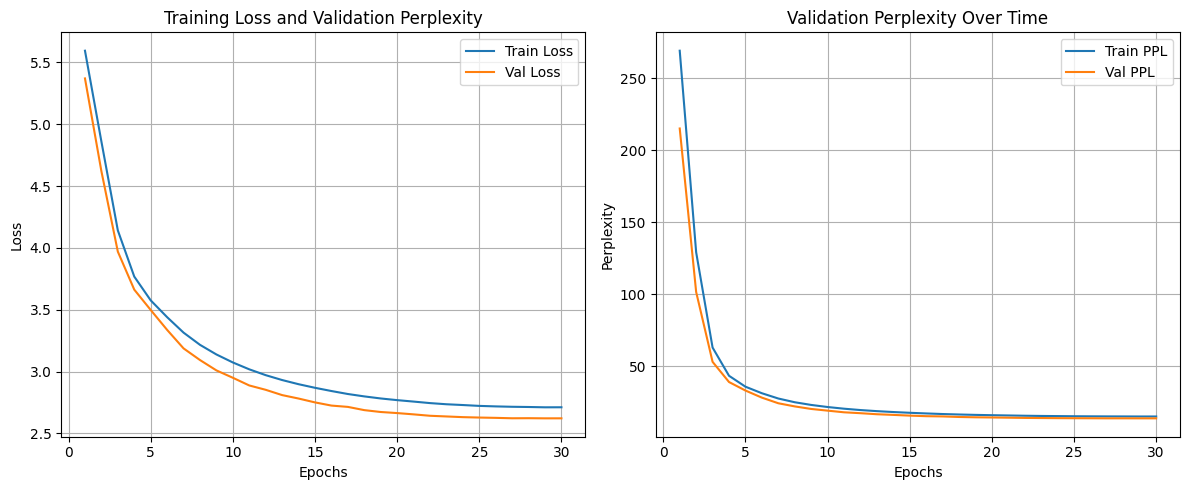

In [9]:
# make train_loss, train_ppl, val_ppl, val_loss and epochs into a DataFrame
history = train_results["history"]
history_df = pd.DataFrame({
    "train_loss": history["train_loss"],
    "train_ppl": history["train_ppl"],
    "val_ppl": history["val_ppl"],
    "val_loss": history["val_loss"],
    "epochs": range(1, len(history["train_loss"]) + 1)
})

display(history_df.head())
display(history_df.tail())

plt.figure(figsize=(12, 5))
# loss 
plt.subplot(1, 2, 1)
plt.plot(history_df['epochs'], history_df["train_loss"], label="Train Loss")
plt.plot(history_df['epochs'], history_df["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.xticks(history_df['epochs'][::int(len(history_df['epochs'])//9)+1])  
plt.title("Training Loss and Validation Perplexity")
plt.legend()
plt.grid()

# perplexity
plt.subplot(1, 2, 2)
plt.plot(history_df['epochs'], history_df["train_ppl"], label="Train PPL")
plt.plot(history_df['epochs'], history_df["val_ppl"], label="Val PPL")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
# plt.xticks(history_df['epochs'][::int(len(history_df['epochs'])//9)+1])  
plt.title("Validation Perplexity Over Time")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [10]:
# compare with exponentiated average negative log likelihood
test_nll = evaluate(model, test_loader, cfg_train.device)
test_ppl = np.exp(test_nll)

val_ppl = train_results["best_val_ppl"]
train_ppl = train_results["best_train_ppl"]

val_nll = torch.log(torch.tensor(val_ppl)).item()
train_nll = torch.log(torch.tensor(train_ppl)).item()

# display in a DataFrame
test_results_df = pd.DataFrame({
    "split": ["train", "val", "test"],
    "loss(NLL)": [train_nll, val_nll, test_nll],
    "perplexity": [train_ppl, val_ppl, test_ppl],
})
display(test_results_df)

,split,loss(NLL),perplexity
0,train,2.711632,15.053831
1,val,2.622116,13.764820
2,test,2.723979,15.240840


### generate text from the trained model

In [11]:
# get a batch from validation set and generate text
context_len = 10
batch_gen = 5
max_new_tokens = 100

context_ids_batch, _ = next(iter(val_loader))
context_ids_batch = context_ids_batch.to(cfg_train.device, non_blocking=True)
# generate text from the model
generated_text = model.generate(context_ids_batch[:batch_gen, :context_len], max_new_tokens=max_new_tokens, temperature=0.9, top_k=20)
print(f">>>> <context>\n", "-" *20, "\n<<<< <generated_text>")
for i, text in enumerate(generated_text):
    print("\n", "-" * 80)
    print(">>>>", decode(text[:context_len].tolist()))
    print("-" * 20)
    print("<<<< ", decode(text[context_len:].tolist()))
    if i + 1 >= batch_gen:
        break

>>>> <context>
 -------------------- 
<<<< <generated_text>

 --------------------------------------------------------------------------------
>>>>  cured.
Draw that
--------------------
<<<<   I peoors to thee, and by you commanded;
But were the mine o'erther Julie bear's daughter.



Enter CASSIO

HAMLET
Why side would not well.



ROMEO
O goder,
Well, h

 --------------------------------------------------------------------------------
>>>>  his.



DESD
--------------------
<<<<  EMONA
O, world; and then, good lord!



MARK ANTONY
You have not so must call him.
Who would speak!
O, If I am think you, and my lord; you are
It be fear him: would have it man to be again,
And sir

 --------------------------------------------------------------------------------
>>>> 
Go, some of you, w
--------------------
<<<<  ould servit to him.



AMILIA
Now, you do a music!



OTHELLO
O, my fair, holy dream, heart

So you set you, lord, but not, but may so: but say,
Doth then, for, let her take thy l